In [8]:
# jupyter extensions
%load_ext autoreload
%autoreload 2
%matplotlib inline

# imports
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as clr
from pyproj import Proj, transform
from pandas_plink import read_plink
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import networkx as nx
import yaml
import sys
import json
from copy import deepcopy

# feems modules
sys.path.append("/project2/jnovembre/jhmarcus/feems-paper/scripts/feems_vw/")
from graph import Graph
from sumstat import SummaryStatistics
from objective import Objective, neg_log_lik_wrapper, loss_wrapper
from feems_opt import FEEMS
from viz import plot_graph#, comp_fit_dist
from viz2 import Viz
from utils import prepare_input, setup_kfold_cv, recover_nnz_entries, create_feems_train_val

# matplotlib plot style
plt.style.use('/project2/jnovembre/jhmarcus/feems-paper/data/whitegrid.mplstyle')
plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def draw_admix_pie(admix_fracs, 
                   x, y, 
                   colors,
                   radius=.18, 
                   inset_width=.5,
                   inset_height=.5,
                   loc=10,
                   linewidth=.2,
                   edgecolor="black",
                   ax=None):
    """Draws a single admixture pie on a axis
    """
    xy = (x, y)
    ax_i = inset_axes(ax, 
                      width=inset_width, 
                      height=inset_height, 
                      loc=loc, 
                      bbox_to_anchor=(x, y),
                      bbox_transform=ax.transData, 
                      borderpad=0)
    wedges, t = ax_i.pie(admix_fracs, 
                         colors=colors, 
                         center=xy, 
                         radius=radius, 
                         wedgeprops={"linewidth": linewidth, 
                                     "edgecolor": edgecolor})

In [12]:
%%time
# input file paths
prefix = "/project2/jnovembre/jhmarcus/feems-paper/data/misc/r1africa1nfb/r1africa1nfb"
coord_path = "{}.coord".format(prefix)
outer_path = "{}.outer".format(prefix)

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink(prefix)
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

# read the eems input files
n, p = genotypes.shape
coord = np.loadtxt(coord_path)
outer = np.loadtxt(outer_path)
outer, edges, grid, ipmap = prepare_input(coord=coord, 
                                          ggrid="/project2/jnovembre/jhmarcus/feems-paper/data/grids/grid_200.shp",
                                          translated=False,
                                          buffer=0,
                                          outer=outer)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 37.50it/s]


CPU times: user 3.82 s, sys: 368 ms, total: 4.19 s
Wall time: 4.26 s


In [13]:
%%time
feems = FEEMS(genotypes, coord, grid, edges)
lamb = .001
alpha = 50
feems.fit_w0_s2() 
feems.fit_quasi_newton(lamb_l2=0.0, lamMercatormth=lamb, lamb_log=alpha, w_init=feems.graph.w0, factr=1e9)

constant-w/variance fit, converged in 143 iterations, train_loss=-2145131.2674549
lambda_l2=0.0000000, lambda=0.0010000, alpha=50.0000000, converged in 120 iterations, train_loss=-2338765.7111435
CPU times: user 40 s, sys: 0 ns, total: 40 s
Wall time: 40.1 s


In [26]:
Viz()

array([[4285800.39554103, 1280343.87854194],
       [4285800.39554103, 1280343.87854194],
       [4285800.39554103, 1280343.87854194],
       ...,
       [ 834896.18094955, 1010539.97842404],
       [ 834896.18094955, 1010539.97842404],
       [ 834896.18094955, 1010539.97842404]])

K=2 ...
K=3 ...
K=4 ...
K=5 ...
K=6 ...
K=7 ...
K=8 ...


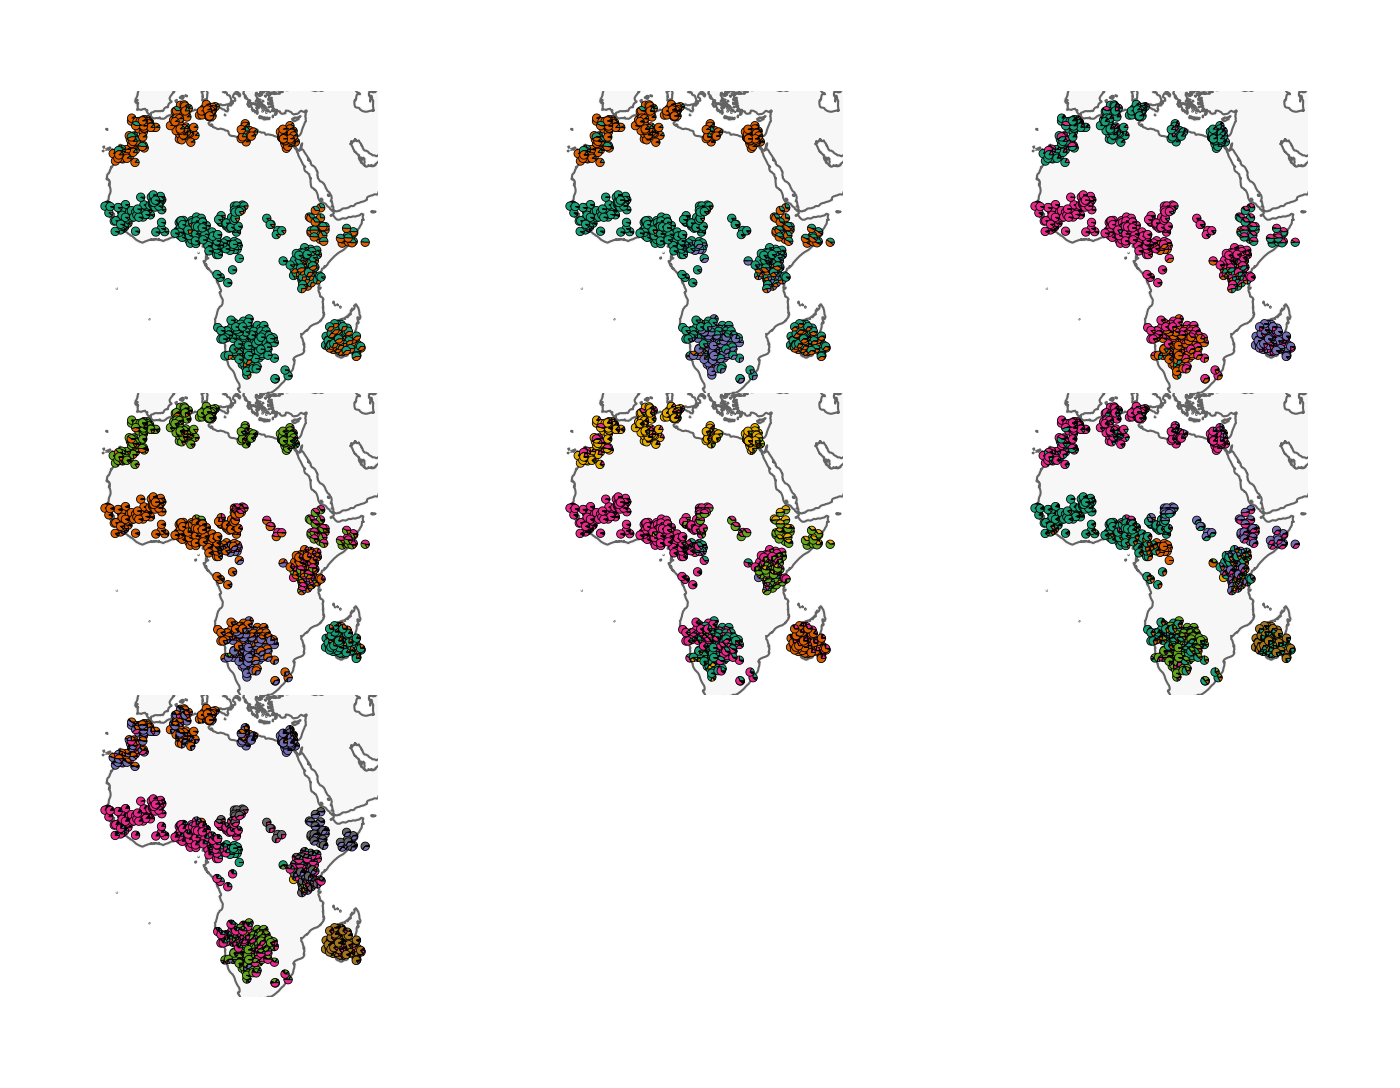

In [48]:
#################### figure params ####################
title_pad = -10
title_loc = "left"
dpi = 300
radius = .07
projection = ccrs.Mercator()
jit_x = np.random.normal(0, 150000, n)
jit_y = np.random.normal(0, 150000, n)

#################### highest lik replicates ####################
r_k2 = np.argmax(np.array([-16447852.433945, -16447852.433941, -16447852.433989, -16447852.433897, -16447852.434116]))
r_k3 = np.argmax(np.array([-16294360.272455, -16294360.272435, -16294360.272427, -16294360.275682, -16294360.272506]))
r_k4 = np.argmax(np.array([-16239107.152757, -16239107.151604, -16239107.149546, -16239107.150282, -16239107.155943]))
r_k5 = np.argmax(np.array([-16194646.700154, -16194646.707037, -16194646.711982, -16194646.702292, -16194646.700789]))
r_k6 = np.argmax(np.array([-16163407.345082, -16163407.366214, -16164857.110730, -16163407.343138, -16163407.346830]))
r_k7 = np.argmax(np.array([-16133833.059438, -16133833.063856, -16139847.150342, -16133833.063421, -16133833.068404]))
r_k8 = np.argmax(np.array([-16110311.198691, -16110311.214062, -16110311.209302, -16110311.217853, -16110311.205529]))

#################### admixture fractions ####################
Q_k2 = np.loadtxt("../output/admixture/r1africa1nfb/r1africa1nfb.K2r{}.Q".format(r_k2+1))
Q_k3 = np.loadtxt("../output/admixture/r1africa1nfb/r1africa1nfb.K3r{}.Q".format(r_k3+1))
Q_k4 = np.loadtxt("../output/admixture/r1africa1nfb/r1africa1nfb.K4r{}.Q".format(r_k4+1))
Q_k5 = np.loadtxt("../output/admixture/r1africa1nfb/r1africa1nfb.K5r{}.Q".format(r_k5+1))
Q_k6 = np.loadtxt("../output/admixture/r1africa1nfb/r1africa1nfb.K6r{}.Q".format(r_k6+1))
Q_k7 = np.loadtxt("../output/admixture/r1africa1nfb/r1africa1nfb.K7r{}.Q".format(r_k7+1))
Q_k8 = np.loadtxt("../output/admixture/r1africa1nfb/r1africa1nfb.K8r{}.Q".format(r_k8+1))

#################### colors ####################
colors_k2 = ["#1b9e77", "#d95f02"] # x
colors_k3 = ["#1b9e77", "#d95f02", "#7570b3"] # x
colors_k4 = ["#7570b3", "#e7298a", "#d95f02", "#1b9e77"] # x
colors_k5 = ["#e7298a", "#66a61e", "#d95f02", "#1b9e77", "#7570b3"] # x 
colors_k6 = ["#1b9e77", "#e7298a", "#7570b3", "#e6ab02", "#d95f02", "#66a61e"] # x
colors_k7 = ["#e6ab02", "#a6761d", "#66a61e", "#7570b3", "#e7298a", "#1b9e77", "#d95f02"] # x 
colors_k8 = ["#1b9e77", "#e6ab02", "#d95f02", "#66a61e", "#666666", "#a6761d", "#7570b3", "#e7298a"] # x

#################### figure setup ####################
fig = plt.figure(dpi=dpi)
spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig, wspace=0.0, hspace=0.0)

#################### axis 00 ####################
print("K=2 ...")
ax_00 = fig.add_subplot(spec[0, 0], projection=projection)
v = Viz(ax_00, feems, projection=projection)
v.draw_map()
ax_00.scatter(v.coord[:,0]+jit_x, v.coord[:,1]+jit_y, marker=".", s=0.0)
for i in range(n):
    draw_admix_pie(Q_k2[i, :], 
                   v.coord[i, 0]+jit_x[i], 
                   v.coord[i, 1]+jit_y[i], 
                   colors_k2, 
                   radius=radius,
                   ax=ax_00)

print("K=3 ...")
#################### axis 01 ####################
ax_01 = fig.add_subplot(spec[0, 1], projection=projection)
v = Viz(ax_01, feems, projection=projection)
v.draw_map()
ax_01.scatter(v.coord[:,0]+jit_x, v.coord[:,1]+jit_y, marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k3[i, :], 
                   v.coord[i, 0]+jit_x[i], 
                   v.coord[i, 1]+jit_y[i], 
                   colors_k3, 
                   radius=radius,
                   ax=ax_01)

#################### axis 10 ####################
print("K=4 ...")
ax_10 = fig.add_subplot(spec[0, 2], projection=projection)
v = Viz(ax_10, feems, projection=projection)
v.draw_map()
ax_10.scatter(v.coord[:,0]+jit_x, v.coord[:,1]+jit_y,  marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k4[i, :], 
                   v.coord[i, 0]+jit_x[i], 
                   v.coord[i, 1]+jit_y[i], 
                   colors_k4, 
                   radius=radius,
                   ax=ax_10)

#################### axis 11 ####################
print("K=5 ...")
ax_11 = fig.add_subplot(spec[1, 0], projection=projection)
v = Viz(ax_11, feems, projection=projection)
v.draw_map()
ax_11.scatter(v.coord[:,0]+jit_x, v.coord[:,1]+jit_y, marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k5[i, :], 
                   v.coord[i, 0]+jit_x[i], 
                   v.coord[i, 1]+jit_y[i], 
                   colors_k5, 
                   radius=radius,
                   ax=ax_11)

#################### axis 20 ####################
print("K=6 ...")
ax_20 = fig.add_subplot(spec[1, 1], projection=projection)
v = Viz(ax_20, feems, projection=projection)
v.draw_map()
ax_20.scatter(v.coord[:,0]+jit_x, v.coord[:,1]+jit_y, marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k6[i, :], 
                   v.coord[i, 0]+jit_x[i], 
                   v.coord[i, 1]+jit_y[i], 
                   colors_k6, 
                   radius=radius,
                   ax=ax_20)

#################### axis 21 ####################
print("K=7 ...")
ax_21 = fig.add_subplot(spec[1, 2], projection=projection)
v = Viz(ax_21, feems, projection=projection)
v.draw_map()
ax_21.scatter(v.coord[:,0]+jit_x, v.coord[:,1]+jit_y, marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k7[i, :], 
                   v.coord[i, 0]+jit_x[i], 
                   v.coord[i, 1]+jit_y[i], 
                   colors_k7, 
                   radius=radius,
                   ax=ax_21)

#################### axis 20 ####################
print("K=8 ...")
ax_30 = fig.add_subplot(spec[2, 0], projection=projection)
v = Viz(ax_30, feems, projection=projection)
v.draw_map()
ax_30.scatter(v.coord[:,0]+jit_x, v.coord[:,1]+jit_y, marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k8[i, :], 
                   v.coord[i, 0]+jit_x[i], 
                   v.coord[i, 1]+jit_y[i], 
                   colors_k8, 
                   radius=radius,
                   ax=ax_30)


In [50]:
fig.savefig("supp-figure-admixturegallery.png", bbox_inches="tight", pad_inches=0.0)